# Pivot review data in pandas

This notebook shows how data can be pivoted by python [pandas](https://pandas.pydata.org/) to reveal insights into the behaviour of reviewers. The use case and data is from Mark Harwood's talk on [entity-centric indexing](https://www.elastic.co/videos/entity-centric-indexing-mark-harwood).

An alternative version of this notebook uses the [Elastic data frames](https://www.elastic.co/guide/en/elastic-stack-overview/master/ml-dataframes.html) to create the same results.

In [1]:
import bz2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

## Read data to pandas DataFrame

In [2]:
csv_handle = bz2.open('./anonreviews.csv.bz2')

reviews = pd.read_csv(csv_handle)

reviews['date'] = pd.to_datetime(reviews['date'])

### Explore data

In [3]:
reviews.head()

,reviewerId,vendorId,rating,date
0,0,0,5,2006-04-07 17:08:00
1,1,1,5,2006-05-04 12:16:00
2,2,2,4,2006-04-21 12:26:00
3,3,3,5,2006-04-18 15:48:00
4,3,4,5,2006-04-18 15:49:00


In [4]:
reviews.describe()

,reviewerId,vendorId,rating
count,578805.000000,578805.000000,578805.000000
mean,174124.098437,60.645267,4.679671
std,116951.972209,54.488053,0.800891
min,0.000000,0.000000,0.000000
25%,70043.000000,20.000000,5.000000
50%,161052.000000,44.000000,5.000000
75%,272697.000000,83.000000,5.000000
max,400140.000000,246.000000,5.000000


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578805 entries, 0 to 578804
Data columns (total 4 columns):
reviewerId    578805 non-null int64
vendorId      578805 non-null int64
rating        578805 non-null int64
date          578805 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 17.7 MB


#### Distribution of reviews (high number of five star ratings)

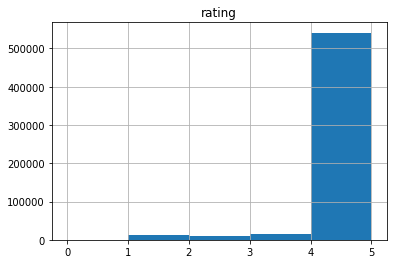

In [6]:
reviews.hist(column="rating", bins = 5)
plt.show()

In [7]:
#### Typically how many vendors does a reviewer review? (mainly one or two)

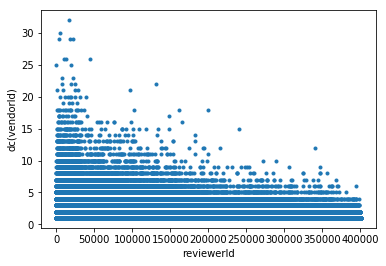

In [8]:
plt.plot(reviews.groupby('reviewerId')['vendorId'].nunique(), '.')
plt.xlabel('reviewerId')
plt.ylabel('dc(vendorId)')
plt.show()

## Aggregate and Pivot data

Pivot data so we get summaries for each reviewer.

In [9]:
aggregations = {
    'rating':'mean',
    'vendorId':'nunique',
    'reviewerId':'count'
}

grouped = reviews.groupby('reviewerId').agg(aggregations)
grouped.columns=['avg_rating', 'dc_vendorId', 'count']

In [10]:
grouped.head()

,avg_rating,dc_vendorId,count
reviewerId,,,
0,5.000000,1,1
1,5.000000,7,9
2,4.000000,5,5
3,4.571429,7,7
4,5.000000,1,1


In [11]:
grouped.describe()

,avg_rating,dc_vendorId,count
count,400141.000000,400141.000000,400141.000000
mean,4.643846,1.357017,1.446503
std,0.813586,0.989413,1.541802
min,0.000000,1.000000,1.000000
25%,5.000000,1.000000,1.000000
50%,5.000000,1.000000,1.000000
75%,5.000000,1.000000,1.000000
max,5.000000,32.000000,168.000000


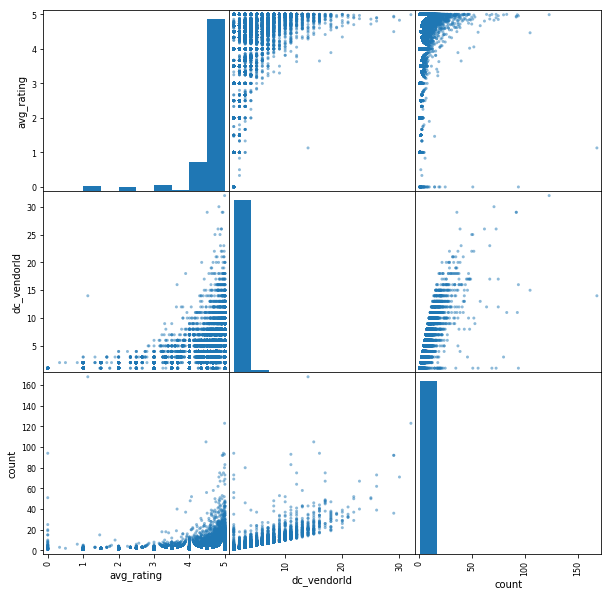

In [12]:
plt.rcParams["figure.figsize"] = (10,10)

scatter_matrix(grouped)
plt.show()

### Find 'haters'

Reviewers that give more than five zero star reviews to one vendor

In [13]:
grouped[ 
    (grouped['dc_vendorId'] == 1) & 
    (grouped['count'] > 5) & 
    (grouped['avg_rating'] == 0)
].sort_values('count', ascending=False)

,avg_rating,dc_vendorId,count
reviewerId,,,
10392,0.0,1,94
17033,0.0,1,51
21046,0.0,1,25
11479,0.0,1,20
27448,0.0,1,19
8185,0.0,1,15
17602,0.0,1,15
13984,0.0,1,10
228129,0.0,1,9


For example, reviewer 10392 gives 94 zero star reviews to vendor 122

In [14]:
reviews[reviews['reviewerId'] == 10392].head()

,reviewerId,vendorId,rating,date
12340,10392,122,0,2006-04-05 15:38:00
12341,10392,122,0,2006-04-06 09:24:00
12342,10392,122,0,2006-04-06 20:24:00
12343,10392,122,0,2006-04-11 07:43:00
12344,10392,122,0,2006-04-11 15:53:00


### Find 'fanboys'

Reviewers that give more than five five star reviews to one vendor

In [15]:
grouped[ 
    (grouped['dc_vendorId'] == 1) & 
    (grouped['count'] > 5) & 
    (grouped['avg_rating'] == 5) 
].sort_values('count', ascending=False)

,avg_rating,dc_vendorId,count
reviewerId,,,
183751,5.0,1,73
260225,5.0,1,69
205864,5.0,1,35
345080,5.0,1,23
179944,5.0,1,22
345082,5.0,1,21
345081,5.0,1,20
345068,5.0,1,20
345069,5.0,1,19


Reviewer 183751 gives 73 five star reviews to vendor 190

In [16]:
reviews[reviews['reviewerId'] == 183751].head()

,reviewerId,vendorId,rating,date
261469,183751,190,5,2006-09-22 16:36:00
261470,183751,190,5,2006-09-22 16:36:00
261471,183751,190,5,2006-09-22 16:35:00
261474,183751,190,5,2006-09-22 15:53:00
261475,183751,190,5,2006-09-22 15:53:00
